In [1]:
#We import the necessary libraries.
%matplotlib inline

In [2]:
import os

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from importlib import reload

In [4]:
from matplotlib import rcParams

#We change the formatting of the plots.
    #rcParams["axes.formatter.useoffset"] = False => Disabling the automatic offset for tick labels, since its False
#full numbers will be displayed.
    #rcParams['axes.formatter.limits'] = -15,15 => If the tick labels are outside of range (-15, 15) Matplotlib will
#use Scientific Notation.
    #rcParams['mathtext.fontset'] = 'stix' => "STIX" font will be used for mathematical symbols, this font is used 
#in publications.
    #rcParams['font.family'] = 'STIXGeneral' => "STIXGeneral" is a part of the font family, ensures the text and
#labels also use this font.
    #rcParams['xtick.direction']='in' => This changes the direction of the x-axis tick marks to point inward,
#towards the plot area.
    #rcParams['ytick.direction']='in' => This changes the direction of the y-axis tick marks to point inward,
#towards the plot area.
rcParams["axes.formatter.useoffset"] = False
rcParams['axes.formatter.limits'] = -15,15
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['xtick.direction']='in'
rcParams['ytick.direction']='in'

#import sys
#sys.path.pop(0)

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [5]:
#We read the datafile.
    #Period < 1 day
    #Planet Radius = not null
    #Stellar Effective Temperature = not null
    #Stellar Radius = not null
    #K Mag (2MASS) = not null
    
df = pd.read_csv('../../data/toi2431_extra/ESM_USPs.csv', comment = "#")

df

,pl_name,hostname,default_flag,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,...,sy_disterr2,sy_vmag,sy_vmagerr1,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_tmag,sy_tmagerr1,sy_tmagerr2
0,K2-137 b,K2-137,1,0.179719,2.800000e-05,-2.800000e-05,0,NaN,NaN,NaN,...,-0.610100,15.940,0.200,-0.200,10.882,0.023,-0.023,13.239600,0.007410,-0.007410
1,TOI-6255 b,TOI-6255,1,0.238182,1.200000e-07,-1.200000e-07,0,NaN,NaN,NaN,...,-0.023600,12.747,0.052,-0.052,8.071,0.020,-0.020,10.445800,0.007303,-0.007303
2,KOI-55 b,KOI-55,1,0.240104,4.000000e-06,-4.000000e-06,0,0.00600,NaN,NaN,...,-48.015000,15.154,0.150,-0.150,15.495,NaN,NaN,15.016000,NaN,NaN
3,K2-141 b,K2-141,1,0.280324,1.500000e-06,-1.500000e-06,0,0.00747,0.00010,-0.00010,...,-0.165400,11.454,0.023,-0.023,8.401,0.023,-0.023,10.029800,0.006000,-0.006000
4,GJ 367 b,GJ 367,1,0.321923,2.000000e-07,-2.000000e-07,0,0.00709,0.00027,-0.00027,...,-0.002835,10.153,0.044,-0.044,5.780,0.020,-0.020,8.031941,0.007430,-0.007430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,HIP 65 A b,HIP 65 A,1,0.980973,3.100000e-06,-3.100000e-06,0,0.01782,0.00020,-0.00021,...,-0.080400,11.000,0.030,-0.030,8.290,0.025,-0.025,9.900500,0.006000,-0.006000
139,Kepler-1258 b,Kepler-1258,1,0.984940,3.180000e-06,-3.180000e-06,0,NaN,NaN,NaN,...,-8.786000,13.929,0.080,-0.080,12.382,0.026,-0.026,13.357500,0.007000,-0.007000
140,Kepler-80 f,Kepler-80,1,0.986787,6.000000e-08,-6.000000e-08,0,0.01750,0.00020,-0.00020,...,-2.894500,15.230,0.172,-0.172,12.253,0.020,-0.020,14.023900,0.006200,-0.006200
141,TOI-1634 b,TOI-1634,1,0.989345,6.000000e-06,-6.000000e-06,0,NaN,NaN,NaN,...,-0.052600,13.217,0.043,-0.043,8.600,0.014,-0.014,11.013600,0.007306,-0.007306


In [6]:
#We calculate the semi major axis of each planet as a double check & to avoid NaN values.
def calc_semi_major(period_days, stellar_mass):
    #We first convert period from days to years.
    period_years = period_days/365.25
    
    #We use Kepler's 3rd Law.
    #Depending on whether the Stellar Mass exists or not, we can either calculate the semi major axis very well or
    #estimate it.
    #We first calculate the semi major axis if stellar mass exists.
    if not np.isnan(stellar_mass):
        semi_major_axis = (period_years ** 2 * stellar_mass) ** (1/3)

    #If the stellar mass does not exist, we calculate an estimate.
    elif np.isnan(stellar_mass):
        semi_major_axis = (period_years ** 2) ** (1/3)

    #We return the semi_major_axis in units of AU.
    return semi_major_axis

#We calculate the semi major axis values.
period_list = list(df["pl_orbper"])
mass_list = list(df["st_mass"])
semi_major = list()

for i, per in enumerate(period_list):
    semi_major_value = calc_semi_major(per, mass_list[i])
    print(f"{semi_major_value} AU")
    semi_major.append(semi_major_value)

0.006232598907287241 AU
0.005299509703476583 AU
0.006000619862223914 AU
0.007478248640286919 AU
0.0070962136398652065 AU
0.007609635680439832 AU
0.009732744459685999 AU
0.009809889827834392 AU
0.009032258584506628 AU
0.010000200774716634 AU
0.009351738699365047 AU
0.006367013127824462 AU
0.010286760682314901 AU
0.00831108823760632 AU
0.007138428965168752 AU
0.008050063012545686 AU
0.010772204498474523 AU
0.010658443191469856 AU
0.005850171399760645 AU
0.006222715463781139 AU
0.011818552774407633 AU
0.011634522106241049 AU
0.01119772697886661 AU
0.012420165433278204 AU
0.009145718178982578 AU
0.012329315498985414 AU
0.013163814270408806 AU
0.01224381248815521 AU
0.011856712702459834 AU
0.012186537156644443 AU
0.012819764450990914 AU
0.012510103912543777 AU
0.012627290057630016 AU
0.013457773817097259 AU
0.012810013989433709 AU
0.013246052754984278 AU
0.010035612338380217 AU
0.012491290736644633 AU
0.013590037580562417 AU
0.013676936005198658 AU
0.011837275801392724 AU
0.0118040928501345

In [7]:
#We take the names, period, planet and stellar radius, stellar effective temperature and K magnitudes.
names = list(df["pl_name"])
period = list(df["pl_orbper"])
pl_radius = list(df["pl_rade"])
st_radius = list(df["st_rad"])
eff_temp = list(df["st_teff"])
#semi_major = list(df["pl_orbsmax"])
k_mag = list(df["sy_kmag"])

#We can also add the values TOI-2431b has to our lists.
names.append("TOI-2431 b")
period.append(0.224) #days
pl_radius.append(1.507338) #Earth Radii
st_radius.append(0.676459) #Solar Radii
eff_temp.append(4079.0) #K
semi_major.append(calc_semi_major(0.224, 0.64)) #AU
k_mag.append(7.554) #mag

In [8]:
#We then calculate the ESM of TOI-2431.01 ourselves.
#First, we have to define a Planck Function.
def Planck_function(wavelength, T):
    """Takes the Temperature. Calculates the Planck Function for given 
    Wavelength and Temperature.
    
    Input:
    ----------------------------------------------------------------------------
    wavelength: Wavelength in meters (Example: 7.5 μm -> 7.5e-6)
    T: Temperature in Kelvin
    
    Output:
    ----------------------------------------------------------------------------
    result: Spectral Radiance in [W/m^3]
    
    """

    #We define the constants of the Planck Function. (SI Units)
    h = 6.62607015e-34  #Planck's constant in [J * s]
    c = 3.0e8           #Speed of light in [m/s]
    k_B = 1.380649e-23  #Boltzmann constant in [J/K]

    #We calculate the Planck Function.
    #For that, we split the formula into different terms from planck 1 to planck 3.
    planck1 = 2 * h * c**2
    planck2 = wavelength ** 5
    planck3 = (h * c) / (wavelength * k_B * T)

    #We calculate the result.
    result = planck1 / (planck2 * (np.exp(planck3) - 1))

    return result

#Then we have to define a Equilibrium Temperature calculator function.
def Equilibrium_Temperature(Teff, Rs, a, f, AB):
    """Takes the Effective (Teff) Temperature of the host star, radius of the 
    Star, Orbital Distance, Day-to-Night Side Heat redistribution and Bond Albedo.
    Returns the Equilibrium Temperature in Kelvin.
    
    Input:
    ----------------------------------------------------------------------------
    Teff: Effective Temperature of the Host Star in Kelvin.
    Rs: Stellar Radius in meters.
    a: Orbital Distance/Semi-Major Axis in meters.
    f: Day-to-Night Side Heat redistribution
    AB: Bond Albedo, bolometric fraction of incident energy that is absorbed
    
    
    Output:
    ----------------------------------------------------------------------------
    result: Equilibrium Temperature in Kelvin.
    
    """

    #We split the formula into different terms from Teq1 to Teq4.
    Teq1 = Teff
    Teq2 = Rs/(2*a)
    Teq3 = f * (1 - AB)

    #We calculate the result.
    result = Teq1 * (Teq2 ** (1/2)) * (Teq3 ** (1/4))

    return result

def ESM_calculator(Teff, Tday, Rp, Rs, mk):
    """Takes the Effective (Teff) Temperature of the host star, Dayside (Tday) 
    Temperature of the planet, the radius of the Planet and the Star and 
    apparent magnitude of the host star in the K Band. Returns the ESM 
    (Emission Spectroscopy Metric) value.
    
    Input:
    ----------------------------------------------------------------------------
    Teff: Effective Temperature of the Host Star in Kelvin.
    Tday: Dayside Temperature of the Planet in Kelvin. (Can be calculated by 
    1.1 times the Equilibrium Temperature of the Planet)
    Rp: Planet Radius in meters.
    Rs: Stellar Radius in meters.
    mk: Apparent magnitude of the host star in the K band.
    
    
    Output:
    ----------------------------------------------------------------------------
    result: ESM (Emission Spectroscopy Metric)
    
    """
    
    #We split the formula into different terms from ESM1 to ESM4.
    ESM1 = 4.26e6
    ESM2 = Planck_function(7.5e-6, Tday) / Planck_function(7.5e-6, Teff)
    ESM3 = (Rp/Rs) ** 2
    ESM4 = 10 ** (-mk/5)

    #We calculate the result.
    result = ESM1 * ESM2 * ESM3 * ESM4

    return result

In [9]:
#We can then calculate the Equilibrium Temperature first.
#NOTE: When calculating the Equilibrium Temperature on this code, zero bond albedo and full day-night heat 
#redistribution is assumed.
#Then we will calculate the Dayside Temperature by multiplying it with 1.1!
    #Teff: Taken from ExoFOP.
    #Rs: Taken from ExoFOP.
    #a: Taken from ExoFOP.
    #f: Taken as 1.
    #AB: Taken as 0.
Teq_toi2431 = Equilibrium_Temperature(4079.0, 0.676459*696340000, 9.32e8, 1, 0)
Tday_toi2431 = Teq_toi2431 * 1.1

print(80 * "-")
print(f"Equilibrium Temperature of TOI-2431b: {Teq_toi2431} Kelvin")
print(f"Dayside Temperature of TOI-2431b: {Tday_toi2431} Kelvin")
print(80 * "-")

#We can finally calculate the ESM value of TOI-2431b.
    #Teff: Taken from ExoFOP.
    #Tday: Calculated.
    #Rp: From Transit analysis.
    #Rs: Taken from ExoFOP.
    #mk: Taken from ExoFOP
ESM_toi2431 = ESM_calculator(4079.0, Tday_toi2431, 1.507338*6378137, 0.676459*696340000, 7.554)
print(80 * "-")
print(f"ESM of TOI-2431b: {ESM_toi2431}")
print(80 * "-")

--------------------------------------------------------------------------------
Equilibrium Temperature of TOI-2431b: 2050.5112790710814 Kelvin
Dayside Temperature of TOI-2431b: 2255.5624069781898 Kelvin
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
ESM of TOI-2431b: 24.510275696841862
--------------------------------------------------------------------------------


In [10]:
#We create a list to contain the calculated Day-side Temperature, Equilibrium Temperature and ESM values of USPs.
ESM = []
Teq = []
Tday = []

#We calculate the ESM values.
for i,planet in enumerate(names):
    #We get the information about the current planet we are looking at.
    current_name = names[i]
    current_period = period[i]
    current_pl_radius = pl_radius[i]
    current_st_radius = st_radius[i]
    current_eff_temp = eff_temp[i]
    current_semi_major = semi_major[i]
    current_k_mag = k_mag[i]

    #We calculate the ESM as follows.
    current_Teq = Equilibrium_Temperature(current_eff_temp, 
                                          current_st_radius * 696340000, 
                                          current_semi_major * 149597870700, 
                                          1, 0)
    current_Tday = current_Teq * 1.1

    current_ESM = ESM_calculator(current_eff_temp, 
                                 current_Tday, 
                                 current_pl_radius * 6378137, 
                                 current_st_radius * 696340000, 
                                 current_k_mag)

    #We add the ESM to the list.
    ESM.append(current_ESM)
    Tday.append(current_Tday)
    Teq.append(current_Teq)

#We also add TOI-2431b's ESM.
#print(ESM)
print(sorted(Teq))

[547.9951236693862, 611.7873760645596, 698.5949777622852, 797.8632992737494, 809.3224058111211, 820.0870635960163, 870.1490917036367, 910.473710500763, 915.7558728758407, 920.7977924734306, 931.3271460286977, 946.1047808439997, 993.2190080721602, 1047.0858502402843, 1058.6605432972099, 1081.3249490859314, 1089.384904093015, 1092.053091635245, 1092.198346084507, 1183.7839333619547, 1195.3322937926534, 1216.597242152893, 1270.4573254909067, 1297.4922431117486, 1310.3954090137972, 1319.8326230428893, 1358.9781871503683, 1366.6113541492768, 1368.005659907773, 1369.142059866812, 1371.3189439466416, 1378.7068768603053, 1379.015215704532, 1405.1653306004735, 1408.879334145559, 1416.9358621222782, 1421.6253642201543, 1428.4226435465675, 1464.8365710393207, 1476.0262751094754, 1511.6949812182909, 1536.6822290738892, 1538.534180026019, 1538.7746820837406, 1554.5434248143838, 1564.618521724895, 1594.7643278872154, 1622.1396722190548, 1639.3194476213316, 1649.8216166102407, 1686.391400575263, 1703

In [11]:
#Now we have to do the plotting.
#For that, first we create a colormap based on the Temperature values.
norm = plt.Normalize(vmin = min(Teq), vmax = max(Teq))
cmap = plt.get_cmap("hot_r")

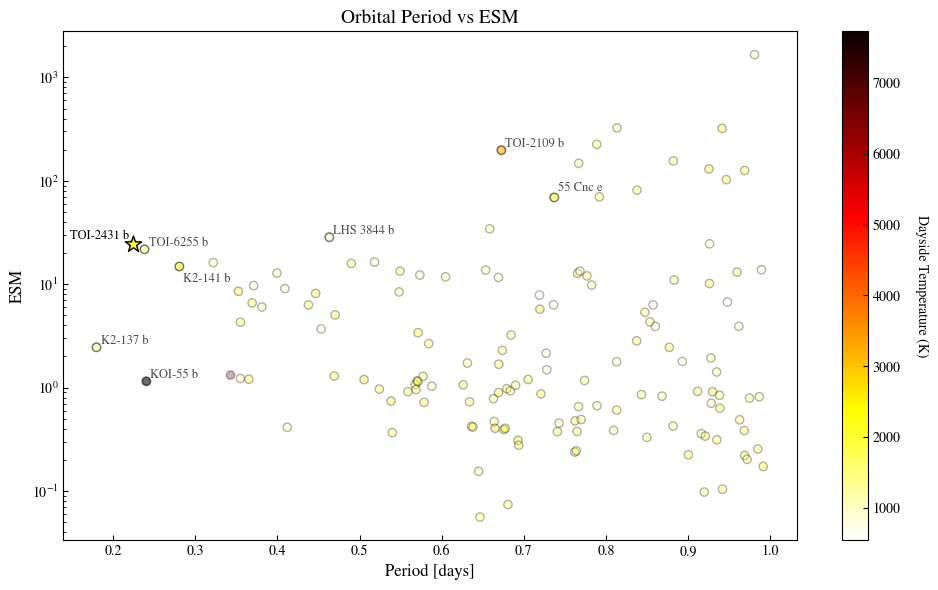

In [12]:
#We then plot the results.
plt.figure(figsize=(10, 6))

scatter = plt.scatter(period, ESM, c = Teq, cmap = cmap, edgecolors = "k", norm = norm, zorder = 3, alpha = 0.3)
cbar = plt.colorbar(scatter)
cbar.set_label('Dayside Temperature (K)', rotation=270, labelpad=20)
cbar.solids.set_alpha(1)

#Now we also add labels to each datapoint.
for i, txt in enumerate(names):
    # if txt != "--":
    if txt != "--" and (txt == "K2-137 b" or txt == "K2-141 b" or txt == "TOI-6255 b" or txt == "KOI-55 b" or 
                        txt == "LHS 3844 b" or txt == "55 Cnc e" or txt == "TOI-2109 b" or txt == "TOI-2431 b"):
        
        if txt == "K2-141 b":
            plt.text(period[i]+0.005, ESM[i]-2.0, txt, fontsize = 9, ha='left', va='top', zorder = 4, alpha = 0.7)
            plt.scatter(period[i], ESM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.4)

        elif txt == "55 Cnc e":
            plt.text(period[i]+0.005, ESM[i]+4.5, txt, fontsize = 9, ha='left', va='bottom', zorder = 4, alpha = 0.7)
            plt.scatter(period[i], ESM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.4)
            
        elif txt == "TOI-2431 b":
            plt.scatter(period[i], ESM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
                        marker = "*", norm = norm, zorder = 4, alpha = 1.0, s = 150)
            plt.text(period[i]-0.005, ESM[i]+0.9, txt, fontsize = 9, ha='right', va='bottom', zorder = 5, alpha = 1.0)
        
        else:
            plt.text(period[i]+0.005, ESM[i], txt, fontsize = 9, ha='left', va='bottom', zorder = 4, alpha = 0.7)
            plt.scatter(period[i], ESM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.4)
        # if txt == "TOI-6255 b":
        #     plt.text(period[i], ESM[i], txt, fontsize = 9, ha='left', va='bottom', zorder = 4, alpha = 0.5)
        # else:
        #     plt.text(period[i], ESM[i], txt, fontsize = 9, ha='right', va='bottom', zorder = 4, alpha = 0.5)

#We add the labels and title
plt.title("Orbital Period vs ESM", fontsize = 14)
plt.xlabel("Period [days]", fontsize = 12)
plt.ylabel("ESM", fontsize = 12)
# plt.xscale("log")
plt.yscale("log")
# plt.grid(True, zorder = 1)
plt.tight_layout()
plt.savefig("ESM_plot", dpi = 500)
plt.show()

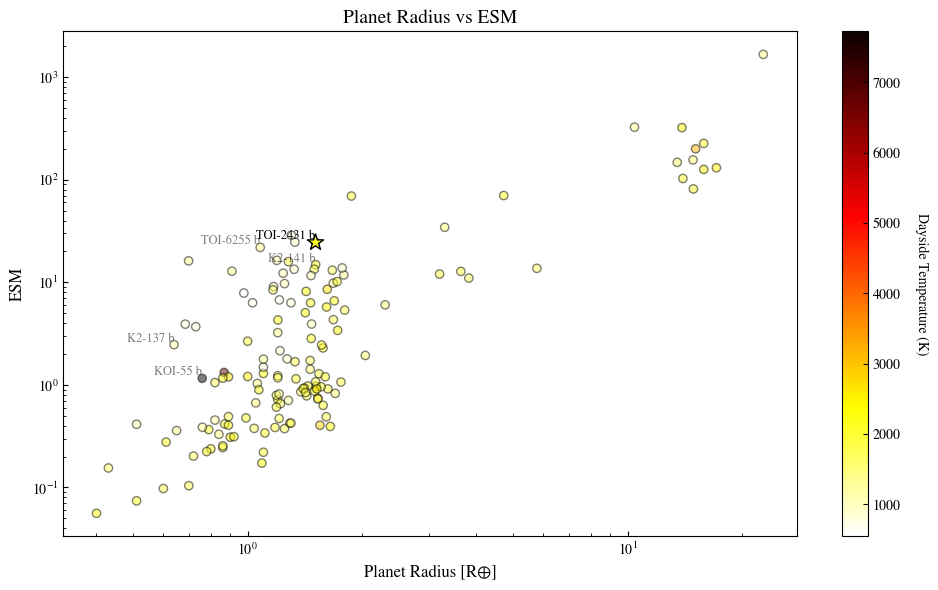

In [13]:
#We then plot the results.
plt.figure(figsize=(10, 6))

scatter = plt.scatter(pl_radius, ESM, c = Teq, cmap = cmap, edgecolors = "k", norm = norm, zorder = 3, alpha = 0.5)
cbar = plt.colorbar(scatter)
cbar.set_label('Dayside Temperature (K)', rotation=270, labelpad=20)
cbar.solids.set_alpha(1)

#Now we also add labels to each datapoint.
for i, txt in enumerate(names):
    # if txt != "--":
    if txt != "--" and (txt == "K2-137 b" or txt == "K2-141 b" or txt == "TOI-6255 b" or txt == "KOI-55 b" or 
                        txt == "TOI-2431 b"):

        if txt == "TOI-2431 b":
            plt.scatter(pl_radius[i], ESM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
                        marker = "*", norm = norm, zorder = 4, alpha = 1.0, s = 150)
            plt.text(pl_radius[i], ESM[i], txt, fontsize = 9, ha='right', va='bottom', zorder = 5, alpha = 1.0)

        else:
            plt.text(pl_radius[i], ESM[i], txt, fontsize = 9, ha='right', va='bottom', zorder = 5, alpha = 0.5)

#We add the labels and title
plt.title("Planet Radius vs ESM", fontsize = 14)
plt.xlabel("Planet Radius [R⊕]", fontsize = 12)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("ESM", fontsize = 12)
# plt.grid(True, zorder = 1)
plt.tight_layout()

plt.show()

In [14]:
#THE ESM According to ExoFOP with the false Radius!

#We can then calculate the Equilibrium Temperature first.
#NOTE: When calculating the Equilibrium Temperature on this code, zero bond albedo and full day-night heat 
#redistribution is assumed.
#Then we will calculate the Dayside Temperature by multiplying it with 1.1!
    #Teff: Taken from ExoFOP.
    #Rs: Taken from ExoFOP.
    #a: Taken from ExoFOP.
    #f: Taken as 1.
    #AB: Taken as 0.
Teq_toi2431 = Equilibrium_Temperature(4079.0, 0.676459*696340000, 9.32e8, 1, 0)
Tday_toi2431 = Teq_toi2431 * 1.1

print(80 * "-")
print(f"Equilibrium Temperature of TOI-2431b: {Teq_toi2431} Kelvin")
print(f"Dayside Temperature of TOI-2431b: {Tday_toi2431} Kelvin")
print(80 * "-")

#We can finally calculate the ESM value of TOI-2431b.
    #Teff: Taken from ExoFOP.
    #Tday: Calculated.
    #Rp: From Transit analysis.
    #Rs: Taken from ExoFOP.
    #mk: Taken from ExoFOP
ESM_toi2431 = ESM_calculator(4079.0, Tday_toi2431, 5.596*6378137, 0.676459*696340000, 7.554)
print(80 * "-")
print(f"ESM of TOI-2431b: {ESM_toi2431}")
print(80 * "-")

--------------------------------------------------------------------------------
Equilibrium Temperature of TOI-2431b: 2050.5112790710814 Kelvin
Dayside Temperature of TOI-2431b: 2255.5624069781898 Kelvin
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
ESM of TOI-2431b: 337.81763116581067
--------------------------------------------------------------------------------


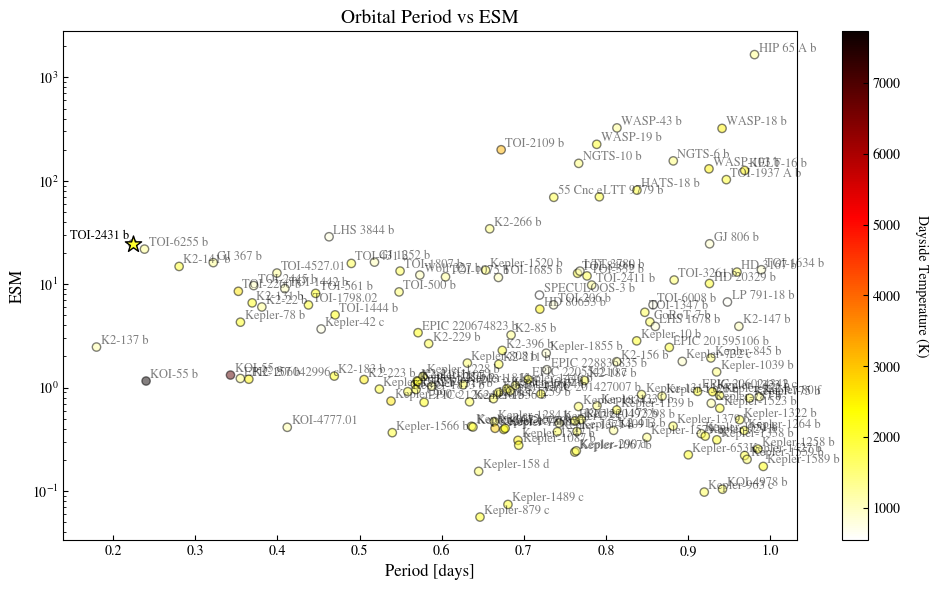

In [15]:
#We then plot the results.
plt.figure(figsize=(10, 6))

scatter = plt.scatter(period, ESM, c = Teq, cmap = cmap, edgecolors = "k", norm = norm, zorder = 3, alpha = 0.5)
cbar = plt.colorbar(scatter)
cbar.set_label('Dayside Temperature (K)', rotation=270, labelpad=20)
cbar.solids.set_alpha(1)

#Now we also add labels to each datapoint.
for i, txt in enumerate(names):
    if txt != "--":
        if txt == "TOI-2431 b":
            plt.scatter(period[i], ESM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
                        marker = "*", norm = norm, zorder = 4, alpha = 1.0, s = 150)
            plt.text(period[i]-0.005, ESM[i]+0.9, txt, fontsize = 9, ha='right', va='bottom', zorder = 5, alpha = 1.0)
        
        else:
            plt.text(period[i]+0.005, ESM[i], txt, fontsize = 9, ha='left', va='bottom', zorder = 4, alpha = 0.5)
        # if txt == "TOI-6255 b":
        #     plt.text(period[i], ESM[i], txt, fontsize = 9, ha='left', va='bottom', zorder = 4, alpha = 0.5)
        # else:
        #     plt.text(period[i], ESM[i], txt, fontsize = 9, ha='right', va='bottom', zorder = 4, alpha = 0.5)

#We add the labels and title
plt.title("Orbital Period vs ESM", fontsize = 14)
plt.xlabel("Period [days]", fontsize = 12)
plt.ylabel("ESM", fontsize = 12)
# plt.xscale("log")
plt.yscale("log")
# plt.grid(True, zorder = 1)
plt.tight_layout()
plt.savefig("ESM_plot", dpi = 500)
plt.show()